In [1]:
# author: Alessandro Vinci

In [2]:
!pip install yfinance

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm

In [4]:
#tickers ["Apple", "Microsoft", "Google", "Tesla",  "Citigroup" ]
ticker_list = ["AAPL", "MSFT", "GOOGL", "TSLA",  "C" ]
data = yf.download( ticker_list , start="2019-01-01", end="2023-12-31")
data = data['Adj Close']
print(data.head())

[*********************100%%**********************]  5 of 5 completed

Ticker           AAPL          C      GOOGL       MSFT       TSLA
Date                                                             
2019-01-02  37.793781  43.809662  52.673550  95.673454  20.674667
2019-01-03  34.029243  43.015804  51.214722  92.153809  20.024000
2019-01-04  35.481926  45.119118  53.841705  96.439819  21.179333
2019-01-07  35.402950  45.511963  53.734329  96.562836  22.330667
2019-01-08  36.077835  45.389198  54.206287  97.262962  22.356667


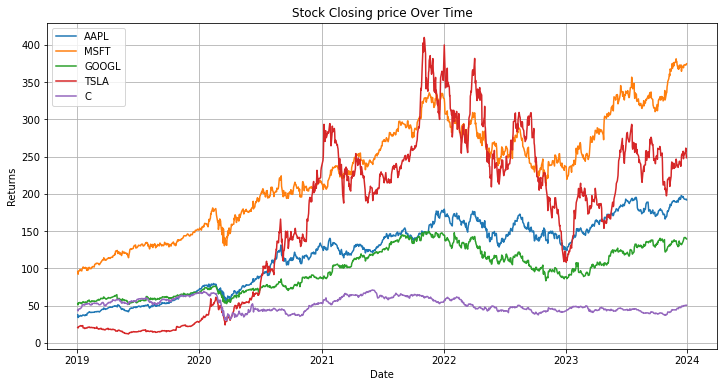

In [5]:
df = pd.DataFrame(data)

# Plot using seaborn
plt.figure(figsize=(12, 6))
for ticker in ticker_list:
    sns.lineplot(x=df.index, y=ticker,  data=data)

plt.title('Stock Closing price Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(ticker_list)
plt.grid(True)
plt.show()

In [6]:
data = data.sort_index()
returns = data.copy(deep=True)

for ticker in ticker_list:
    returns[ticker + " prev_day"] = data[ticker].shift(1)
    returns = returns.dropna()
    returns[ticker + " returns"] = np.log(returns[ticker] / returns[ticker + " prev_day"])
    
display(returns.head(2))

returns = returns[[col for col in returns.columns if "returns" in col]]
returns

Ticker,AAPL,C,GOOGL,MSFT,TSLA,AAPL prev_day,AAPL returns,MSFT prev_day,MSFT returns,GOOGL prev_day,GOOGL returns,TSLA prev_day,TSLA returns,C prev_day,C returns
Date,,,,,,,,,,,,,,,
2019-01-03,34.029243,43.015804,51.214722,92.153809,20.024000,37.793781,-0.104924,95.673454,-0.037482,52.673550,-0.028086,20.674667,-0.031978,43.809662,-0.018287
2019-01-04,35.481926,45.119118,53.841705,96.439819,21.179333,34.029243,0.041803,92.153809,0.045460,51.214722,0.050021,20.024000,0.056094,43.015804,0.047738


Ticker,AAPL returns,MSFT returns,GOOGL returns,TSLA returns,C returns
Date,,,,,
2019-01-03,-0.104924,-0.037482,-0.028086,-0.031978,-0.018287
2019-01-04,0.041803,0.045460,0.050021,0.056094,0.047738
2019-01-07,-0.002228,0.001275,-0.001996,0.052935,0.008669
2019-01-08,0.018884,0.007224,0.008745,0.001164,-0.002701
2019-01-09,0.016839,0.014198,-0.003433,0.009438,0.016452
...,...,...,...,...,...
2023-12-22,-0.005563,0.002780,0.007591,-0.007731,0.005125
2023-12-26,-0.002845,0.000214,0.000212,0.015988,0.009393
2023-12-27,0.000518,-0.001576,-0.008159,0.018647,0.002335


## MARKOVITZ

In [7]:
TRADING_DAYS = 252
        
def show_statistics(returns):
    avg_returns = returns.mean() * TRADING_DAYS
    cov_list = returns.cov() * TRADING_DAYS  

In [8]:
TRADING_DAYS = 252
risk_free = 0.03
def compute_portfolio_metrics(portfolio_weights):
    portfolio_returns = np.sum(returns.mean()*portfolio_weights) * TRADING_DAYS
    portfolio_std = np.sqrt( np.dot(portfolio_weights.T, np.dot(returns.cov() * TRADING_DAYS, portfolio_weights) ))
    sharpe_ratio = (portfolio_returns - risk_free) / portfolio_std
    
    return portfolio_returns, portfolio_std, sharpe_ratio

In [9]:
compute_portfolio_metrics(np.array([0.1,0.2,0.3,0.2,0.2]) )

(0.25131666628626903, 0.30698047755928476, 0.7209470388667562)

In [10]:
def simulate_portfolios(n, returns):
    portfolio_means = []
    portfolio_weights = []
    portfolio_risks = []
    portfolio_sharpe = []
    for i in range(n):
        weight_instance = np.random.random(len(ticker_list))
        #normalize to make sum =1
        weight_instance = weight_instance / np.sum(weight_instance)
        portfolio_weights.append(weight_instance)
        
        #compute returns for this set of weights
        expected_ret = np.sum(returns.mean() * weight_instance) * TRADING_DAYS
        portfolio_means.append(expected_ret)
        #compute std for this set of weights
        expected_risk = np.sqrt(np.dot(weight_instance.T, np.dot(returns.cov() * TRADING_DAYS, weight_instance) )) 
        portfolio_risks.append(expected_risk)
        #compute sharpe ratio for this set of weights
        sharpe_ratio = (expected_ret - risk_free) / expected_risk
        portfolio_sharpe.append(sharpe_ratio)
        
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks), np.array(portfolio_sharpe)

In [11]:
p_weights, p_returns, p_risks, p_sharpe = simulate_portfolios(20000, returns)

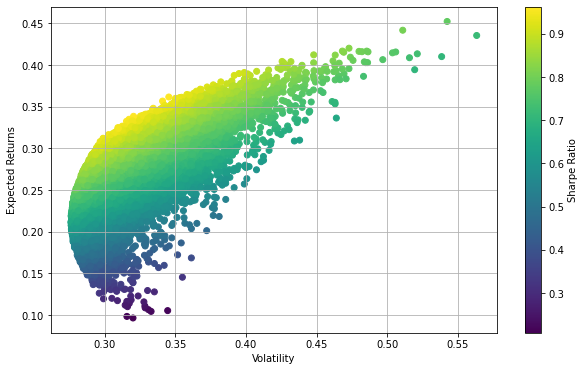

In [12]:
def display_portfolios(returns, risks, sharpe):
    plt.figure(figsize=(10,6))
    plt.scatter(risks, returns, c = sharpe, marker = 'o')
    plt.grid('True')
    plt.xlabel('Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label="Sharpe Ratio")
    plt.show()

display_portfolios(p_returns, p_risks, p_sharpe)

### Optimize my portfolio search

In [13]:
def minimize_sharpe(weights):  
    return - compute_portfolio_metrics(weights)[2] 

In [14]:
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(len(ticker_list)))
initializer = len(ticker_list) * [1./len(ticker_list),]

import scipy.optimize as optimize
optimal_sharpe=optimize.minimize(minimize_sharpe,
                                 initializer,
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)

optimal_sharpe_weights = optimal_sharpe['x'].round(4)
print(list(zip(ticker_list,list(optimal_sharpe_weights))))

optimal_stats = compute_portfolio_metrics(optimal_sharpe_weights)

print('Optimal Portfolio Return: ', round(optimal_stats[0]*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats[1]*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats[2],4))

[('AAPL', 0.6381), ('MSFT', 0.1882), ('GOOGL', 0.0), ('TSLA', 0.1736), ('C', 0.0)]
Optimal Portfolio Return:  34.5979
Optimal Portfolio Volatility:  32.4256
Optimal Portfolio Sharpe Ratio:  0.9745


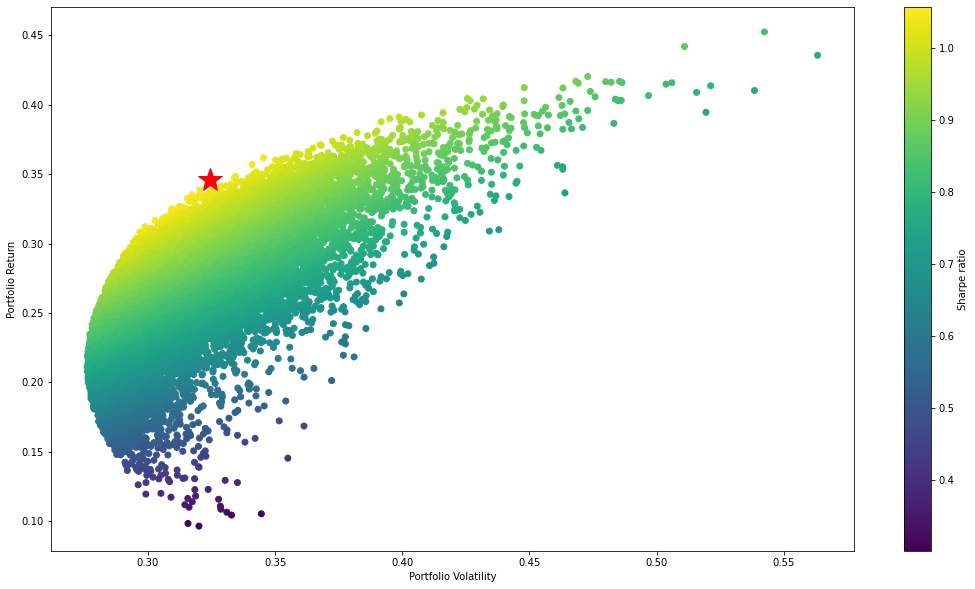

In [15]:
import matplotlib.pyplot as plt 

# initialize figure size
plt.figure(figsize=(18,10))

plt.scatter(p_risks,
            p_returns,
            c = (p_returns / p_risks),
            marker = 'o')


plt.plot(compute_portfolio_metrics(optimal_sharpe_weights)[1],
         compute_portfolio_metrics(optimal_sharpe_weights)[0],
         'r*',
         markersize = 25.0)


plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe ratio')

# CAPM

In [30]:
#market data
market = yf.download( 'SPY' , start="2019-01-01", end="2023-12-31") 
market = market.sort_index()
market_returns = market.copy(deep=True)

market_returns["prev_day"] = market_returns["Adj Close"].shift(1)
market_returns = market_returns.dropna()
market_returns["returns"] = np.log(market_returns["Adj Close"] / market_returns["prev_day"])

market_returns

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,prev_day,returns
Date,,,,,,,,
2019-01-03,248.229996,248.570007,243.669998,244.210007,223.637161,144140700,229.104202,-0.024152
2019-01-04,247.589996,253.110001,247.169998,252.389999,231.128021,142628800,223.637161,0.032947
2019-01-07,252.690002,255.949997,251.690002,254.380005,232.950378,103139100,231.128021,0.007854
2019-01-08,256.820007,257.309998,254.000000,256.769989,235.139008,102512600,232.950378,0.009351
2019-01-09,257.559998,258.910004,256.190002,257.970001,236.237961,95006600,235.139008,0.004663
...,...,...,...,...,...,...,...,...
2023-12-22,473.859985,475.380005,471.700012,473.649994,470.664490,67126600,469.720490,0.002008
2023-12-26,474.070007,476.579987,473.989990,475.649994,472.651886,55387000,470.664490,0.004214
2023-12-27,475.440002,476.660004,474.890015,476.510010,473.506470,68000300,472.651886,0.001806


In [31]:
def beta_calculator(ticker):
    market_comparison =  pd.DataFrame()
    market_comparison['market'] = market_returns['returns']
    market_comparison[ticker] = returns[ticker+ " returns"]
    matrix_cov = market_comparison.cov()
    cov_index_stock = matrix_cov[ticker][0]
    market_var = market_comparison['market'].var()
    
    print('Beta {}: '.format(ticker), cov_index_stock / market_var)
    return cov_index_stock / market_var

betas ={}
for ticker in ticker_list:
    beta = beta_calculator(ticker)
    betas[ticker] = beta

Beta AAPL:  1.2326219187053593
Beta MSFT:  1.194894390898732
Beta GOOGL:  1.1524597643480885
Beta TSLA:  1.5499405895467695
Beta C:  1.3468953841797568


In [32]:
def regression(ticker):
    market_comparison =  pd.DataFrame()
    market_comparison['market'] = market_returns['returns']
    market_comparison[ticker] = returns[ticker+ " returns"]
    y = market_comparison[ticker]
    X = sm.add_constant(market_comparison["market"])
    OLS_regr = sm.OLS(y, X).fit()
    print(OLS_regr.params[1])
    return OLS_regr.params[1]

In [33]:
betas_reg ={}
for ticker in ticker_list:
    beta = regression(ticker)
    betas_reg[ticker] = beta

1.2326219187053584
1.1948943908987308
1.152459764348087
1.549940589546768
1.3468953841797546


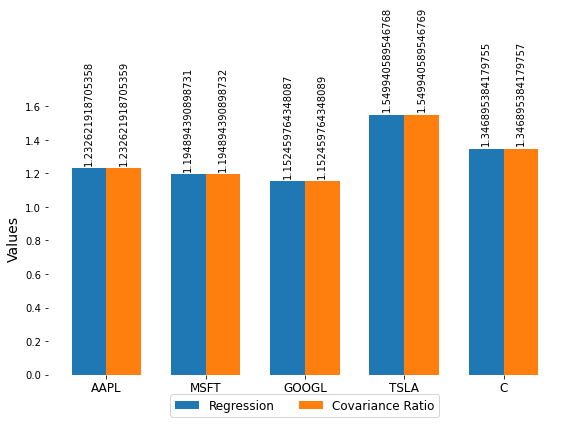

In [34]:
dict1, dict2 = betas_reg, betas


# Extract the keys (tickers) and values from both dictionaries
tickers = list(dict1.keys())
values1 = list(dict1.values())
values2 = list(dict2.values())

# Set the positions and width for the bars
x = np.arange(len(tickers))  # the label locations
width = 0.35  # the width of the bars

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size

# Plotting
bars1 = ax.bar(x - width/2, values1, width, label='Regression')
bars2 = ax.bar(x + width/2, values2, width, label='Covariance Ratio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(tickers, fontsize=12)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Add value labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.15f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10,rotation=90,)

# Remove the box (spines) around the graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

add_labels(bars1)
add_labels(bars2)

# Adjust the layout to make room for the labels
plt.tight_layout()
plt.show()

In [35]:
def compute_expected_returns(beta, risk_free):
    market_expected_returns = market_returns['returns'].mean() * TRADING_DAYS
    return risk_free + beta * (market_expected_returns - risk_free)

In [36]:
TRADING_DAYS = 252
risk_free = 0.03
def compute_portfolio_metrics(portfolio_weights):
    
    returns_list=[]
    for ticker in ticker_list:
        ticker_expected_ret = compute_expected_returns(betas[ticker], risk_free)
        returns_list.append(ticker_expected_ret)
    portfolio_returns = np.sum(np.array(returns_list)*portfolio_weights)
    
    portfolio_std = np.sqrt( np.dot(portfolio_weights.T, np.dot(returns.cov() * TRADING_DAYS, portfolio_weights) ))
    sharpe_ratio = (portfolio_returns - risk_free) / portfolio_std
    
    return portfolio_returns, portfolio_std, sharpe_ratio

In [37]:
# returns, risks, sharpe
compute_portfolio_metrics(np.array([0.1,0.2,0.3,0.2,0.2]) )

(0.1780947081897197, 0.30698047755928476, 0.4824238641075126)